### Feature Creation: MathematicalCombination
The MathematicalCombination() applies basic mathematical operations **[‘sum’, ‘prod’, ‘mean’, ‘std’, ‘max’, ‘min’]** to multiple features, returning one or more additional features as a result.

For this demonstration, we use the UCI Wine Quality Dataset.

The data is publicly available on **[UCI repository](https://archive.ics.uci.edu/ml/datasets/Wine+Quality)** 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline as pipe
from sklearn.preprocessing import StandardScaler

from feature_engine.creation import MathematicalCombination
from  feature_engine.imputation import MeanMedianImputer

pd.pandas.set_option('display.max_columns', None)

In [2]:
#Read data
data = pd.read_csv('winequality-red.csv', sep=';')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


**This Data contains 11 Features, All numerical, with No missing values.**

In [3]:
# Let's transform the Target, i.e Quality into a binary classification problem:
bins = [0,5,10]
labels = [0, 1] # 'low'=0, 'high'=1
data['quality_range']= pd.cut(x=data['quality'], bins=bins, labels=labels)

print(data[['quality_range','quality']].head(5))

data.drop('quality', axis=1, inplace = True) 


  quality_range  quality
0             0        5
1             0        5
2             0        5
3             1        6
4             0        5


### Sum and Mean Combinators:
Let's create two new variables:
- avg_acidity = mean(fixed acidity, volatile acidity)
- total_minerals = sum(Total sulfure dioxide, sulphates)


In [4]:
# Create the Combinators
math_combinator_mean = MathematicalCombination(
    variables_to_combine=['fixed acidity', 'volatile acidity'],
    math_operations = ['mean'],
    new_variables_names = ['avg_acidity']
)
math_combinator_sum = MathematicalCombination(
    variables_to_combine=['total sulfur dioxide', 'sulphates'],
    math_operations = ['sum'],
    new_variables_names = ['total_minerals']
)

# Fit the Mean Combinator on Training data
math_combinator_mean.fit(data)
# Transform the data
data_t = math_combinator_mean.transform(data)

# We can combine both steps in a single call with ".fit_transform()" methode
data_t = math_combinator_sum.fit_transform(data_t)

In [5]:
data_t.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_range,avg_acidity,total_minerals
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,4.05,34.56
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0,4.34,67.68
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0,4.28,54.65
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1,5.74,60.58
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,4.05,34.56


You can check the mappings between each new variable and the operation it's created with in the **combination_dict_**

In [6]:
math_combinator_mean.combination_dict_

{'avg_acidity': 'mean'}

### Pipeline Example

We can put all these transformations into single pipeline:
1. Create new variables
2. Scale features
3. Apply simple LogisticRegression classifier to predict the wine quality range

See more on how to use Piplines in these **[examples](https://github.com/solegalli/feature_engine/tree/master/examples/Pipelines)**

In [7]:
X = data.drop(['quality_range'], axis = 1)
y = data.quality_range
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.1,
                                                    random_state=0,
                                                    shuffle=True,
                                                    stratify = y
                                                   )
X_train.shape, X_test.shape

((1439, 11), (160, 11))

In [8]:
value_pipe = pipe([
    # Create two new features using the min and max combinators
    ('math_combinator_mean', MathematicalCombination(variables_to_combine=['fixed acidity', 'volatile acidity'],
                                                     math_operations = ['mean'],
                                                     new_variables_names = ['avg_acidity'])),
     
    # Create three new features using the mean and sum combinators
    ('math_combinator_sum', MathematicalCombination(variables_to_combine=['total sulfur dioxide', 'sulphates'],
                                                    math_operations = ['sum'],
                                                    new_variables_names = ['total_minerals'])),
    
    # scale features
    ('scaler', StandardScaler()),
    
    # LogisticRegression
    ('LogisticRegression', LogisticRegression())
     ])

In [9]:
value_pipe.fit(X_train, y_train)

Pipeline(steps=[('math_combinator_mean',
                 MathematicalCombination(math_operations=['mean'],
                                         new_variables_names=['avg_acidity'],
                                         variables_to_combine=['fixed acidity',
                                                               'volatile '
                                                               'acidity'])),
                ('math_combinator_sum',
                 MathematicalCombination(math_operations=['sum'],
                                         new_variables_names=['total_minerals'],
                                         variables_to_combine=['total sulfur '
                                                               'dioxide',
                                                               'sulphates'])),
                ('scaler', StandardScaler()),
                ('LogisticRegression', LogisticRegression())])

In [10]:
pred_train = value_pipe.predict(X_train)
pred_test = value_pipe.predict(X_test)

In [11]:
print('LogisticRegression Model train accuracy score: {}'.format(accuracy_score(y_train, pred_train)))
print()
print('LogisticRegression Model train accuracy score: {}'.format(accuracy_score(y_test, pred_test)))

LogisticRegression Model train accuracy score: 0.744266851980542

LogisticRegression Model train accuracy score: 0.75


In [12]:
print('LogisticRegression Model test classification report: \n\n {}'.format(classification_report(y_test,pred_test)))

LogisticRegression Model test classification report: 

               precision    recall  f1-score   support

           0       0.73      0.73      0.73        74
           1       0.77      0.77      0.77        86

    accuracy                           0.75       160
   macro avg       0.75      0.75      0.75       160
weighted avg       0.75      0.75      0.75       160



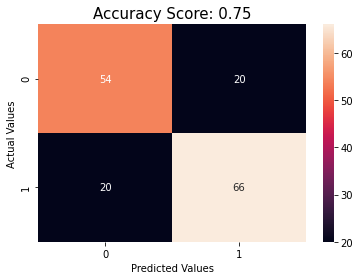

In [13]:
score = round(accuracy_score(y_test, pred_test), 3)
cm = confusion_matrix (y_test, pred_test)

sns.heatmap(cm, annot=True, fmt=".0f")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Accuracy Score: {0}'.format(score), size = 15)
plt.show()

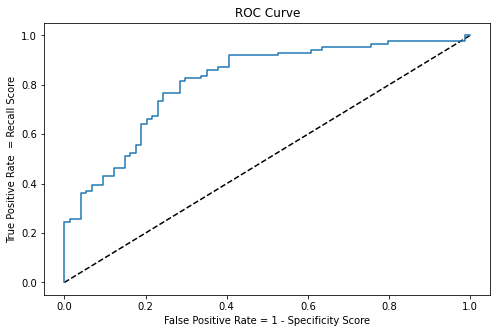

In [14]:
#Predict probabilities for the test data
probs = value_pipe.predict_proba(X_test)[:,1]  

#Get the ROC Curve
fpr, tpr, thresholds  = roc_curve(y_test, probs)

# Plot ROC curve
plt.figure(figsize=(8,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate = 1 - Specificity Score')
plt.ylabel('True Positive Rate  = Recall Score')
plt.title('ROC Curve')
plt.show()